In [1]:
import numpy as np
import requests
import pandas as pd
import datetime
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize': (11, 4)})
import locale
locale.setlocale(locale.LC_ALL, 'pt_BR.UTF-8')

'pt_BR.UTF-8'

In [2]:
DOWNLOADS_FOLDER = 'data/downloaded'
EXPORTS_FOLDER = 'data/exported'
Path(DOWNLOADS_FOLDER).mkdir(parents=True, exist_ok=True)

In [19]:
font = {'fontname':'Noto Mono'}
plt.rc('font', **{'family':'Noto Mono'})

In [3]:
frames = []
for p in Path(DOWNLOADS_FOLDER).glob('*.xls'):
    try:
        df = pd.read_excel(p, skiprows=2)
    except Exception as e:
        print(p, e)
    frames.append(df)

df = pd.concat(frames)

data/downloaded/02FEV2021.xls 
data/downloaded/29FEV2021.xls Unsupported format, or corrupt file: Expected BOF record; found b'<!DOCTYP'
data/downloaded/10FEV2021.xls 


In [4]:
df.Data.max()

Timestamp('2021-05-11 00:00:00')

In [5]:
df.head()

,Data,Tipo,Area,Empresa,Linha,Passageiros Pagtes Em Dinheiro,Passageiros Comum e VT,Passageiros Pgts Bu Comum M,Passageiros Pagtes Estudante,Passageiros Pgts Bu Est Mensal,Passageiros Pgts Bu Vt Mensal,Passageiros Pagantes,Passageiros Int Ônibus->Ônibus,Passageiros Com Gratuidade,Passageiros Com Gratuidade Est,Tot Passageiros Transportados
0,2020-06-15,CONCESSAO,AREA 2,201,N40211 - METRO ITAQUERA/TERM VL CARRAO,4,28,1,0,0,0,33,16,2,0,51
1,2020-06-15,CONCESSAO,AREA 2,201,N40511 - TERM V CARRAO/METRO ITAQUERA,1,24,2,0,0,0,27,6,5,0,38
2,2020-06-15,CONCESSAO,AREA 2,201,200210 - TERM P D PEDRO II/TERM BANDEIR,22,433,43,2,0,0,500,831,253,1,1585
3,2020-06-15,CONCESSAO,AREA 2,201,210010 - TERM V CARRAO/PCA DA SE CIRC,393,2248,106,21,0,0,2768,1813,1121,4,5706
4,2020-06-15,CONCESSAO,AREA 2,201,210021 - TERM VL CARRAO/TERM PQ D PEDRO,0,2,0,0,0,0,2,0,0,0,2


In [20]:
# features
cols = {
    'Data': 'date',
    'Tipo': 'type',
    'Area': 'area',
    'Empresa': 'company',
    'Linha': 'line_name',
    'Passageiros Pagtes Em Dinheiro': 'paid_money',
    'Passageiros Comum e VT': 'paid_common_vt',
    'Passageiros Pgts Bu Comum M': 'paid_bu_common_monthly',
    'Passageiros Pagtes Estudante': 'paid_student',
    'Passageiros Pgts Bu Est Mensal': 'paid_bu_student_monthly',
    'Passageiros Pgts Bu Vt Mensal': 'paid_bu_vt_monthly',
    'Passageiros Pagantes': 'paid',
    'Passageiros Int Ônibus->Ônibus': 'integrated_bus',
    'Passageiros Com Gratuidade': 'free',
    'Passageiros Com Gratuidade Est': 'free_student',
    'Tot Passageiros Transportados': 'total_passengers'
}
df = df.rename(columns=cols)
df['date'] = pd.to_datetime(df['date'])
df['day_of_week'] = df['date'].dt.day_name()
df['week'] = df['date'].dt.to_period('W')
df['month'] = df['date'].dt.to_period('M')
df['line_code'] = df.line_name.str[0:4] + '-' + df.line_name.str[4:6]

In [21]:
# filters
df = df[df.total_passengers > 0]
df.line_name.nunique()

1498

In [22]:
df_sum = pd.read_csv(DOWNLOADS_FOLDER + '/leitos_summary/20210511_leitos_internacoes.csv', sep=';', encoding='utf8', decimal=',')

In [23]:
df_sum.groupby('nome_drs').size()

nome_drs
DRS 02 Araçatuba                358
DRS 03 Araraquara               358
DRS 04 Baixada Santista         358
DRS 05 Barretos                 358
DRS 06 Bauru                    358
DRS 07 Campinas                 358
DRS 08 Franca                   358
DRS 09 Marília                  358
DRS 10 Piracicaba               358
DRS 11 Presidente Prudente      358
DRS 12 Registro                 358
DRS 13 Ribeirão Preto           358
DRS 14 São João da Boa Vista    358
DRS 15 São José do Rio Preto    358
DRS 16 Sorocaba                 358
DRS 17 Taubaté                  358
Estado de São Paulo             358
Grande SP Leste                 358
Grande SP Norte                 358
Grande SP Oeste                 358
Grande SP Sudeste               358
Grande SP Sudoeste              358
Município de São Paulo          358
dtype: int64

In [24]:
df_sum['date'] = pd.to_datetime(df_sum['datahora'], format='%d/%m/%Y')

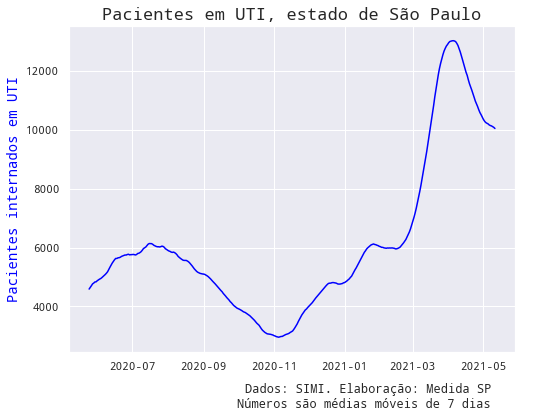

In [25]:
df_sum_state = df_sum[df_sum.nome_drs.str.contains('Estado')]

ma = 7
hosp = df_sum_state.reset_index().set_index('date').shift(0)[['pacientes_uti_ultimo_dia']].rolling(window=ma).mean()

yscale = 'linear'
# yscale = 'log'
a = 'pacientes_uti_ultimo_dia'
b = 'ocupacao_leitos'

# create figure and axis objects with subplots()
fig,ax = plt.subplots(figsize=(8,6))
df_tmp = hosp.reset_index()
df_tmp = df_tmp[df_tmp.date >= '2020-03-15']
# make a plot
ax.plot(df_tmp.date, df_tmp[a], color="blue")
# set x-axis label
# ax.set_xlabel("Data",fontsize=14)
# set y-axis label
ax.set_ylabel("Pacientes internados em UTI",color="Blue",fontsize=14)

# # twin object for two different y-axis on the sample plot
# ax2 = ax.twinx()
# # make a plot with different y-axis using second axis object
# ax2.plot(df_tmp.date, df_tmp[b], color="blue")
# ax2.set_ylabel("Pacientes internados em UTI",color="blue",fontsize=14)

ax.set_title("Pacientes em UTI, estado de São Paulo", fontsize=17)
ax.annotate('Dados: SIMI. Elaboração: Medida SP\nNúmeros são médias móveis de 7 dias',
            xy=(0.92, 0.07), xycoords='figure fraction',
            horizontalalignment='right', verticalalignment='top',
            fontsize=12)

plt.yscale(yscale)
plt.show()


fig.savefig(f'charts/uti_sp.png', dpi=300, bbox_inches='tight')

df_tmp[['date', 'pacientes_uti_ultimo_dia']].to_csv('exports/leitos_estado.csv', index=False)

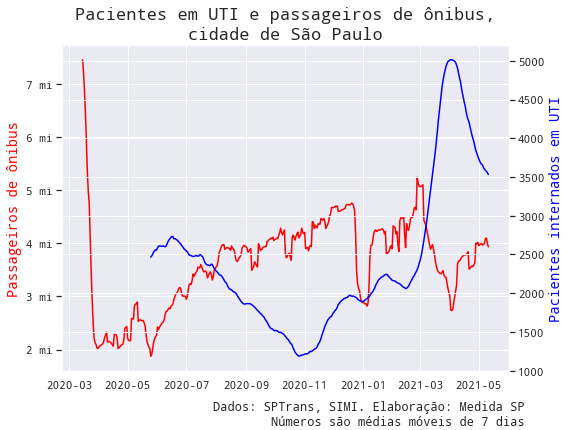

In [26]:
df_sum_state = df_sum[df_sum.nome_drs.str.contains('Município')]

ma = 7
# bus = df_line_total_daily.groupby('date').agg({'compared_to_baseline': 'mean'}).rolling(window=7).mean()
bus = df.groupby('date').agg({'total_passengers': 'sum'}).rolling(window=ma).mean()
hosp = df_sum_state.reset_index().set_index('date').shift(0)[['pacientes_uti_ultimo_dia']].rolling(window=ma).mean()

both = bus.join(hosp, how='left')

yscale = 'linear'
# yscale = 'log'
b = 'pacientes_uti_ultimo_dia'
a = 'total_passengers'

# create figure and axis objects with subplots()
fig,ax = plt.subplots(figsize=(8,6))
df_tmp = both.reset_index()
df_tmp = df_tmp[df_tmp.date >= '2020-03-15']
# make a plot
ax.plot(df_tmp.date, df_tmp[a], color="red")
# set x-axis label
# ax.set_xlabel("Data",fontsize=14)
# set y-axis label

ax.set_ylabel("Passageiros de ônibus",color="red",fontsize=14)
ax.set_title("Pacientes em UTI e passageiros de ônibus,\ncidade de São Paulo", fontsize=17)


# twin object for two different y-axis on the sample plot
ax2 = ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(df_tmp.date, df_tmp[b], color="blue")
ax2.set_ylabel("Pacientes internados em UTI",color="blue",fontsize=14)

ax.yaxis.set_major_formatter(lambda x, p: format(int(x/1000000)) + ' mi')
ax2.yaxis.set_major_formatter(lambda x, p: format(int(x/1000)) + ' mil')

ax.annotate('Dados: SPTrans, SIMI. Elaboração: Medida SP\nNúmeros são médias móveis de 7 dias',
            xy=(0.92, 0.07), xycoords='figure fraction',
            horizontalalignment='right', verticalalignment='top',
            fontsize=12)

plt.yscale(yscale)
plt.show()
fig.savefig(f'charts/passageiros_uti_sp_sp.png', dpi=300, bbox_inches='tight')

df_tmp[['date', 'pacientes_uti_ultimo_dia', 'total_passengers']].to_csv('exports/leitos_municipio.csv', index=False)